## Vector Autoregression

In [51]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplolib', 'inline')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.5f}'.format

In [52]:
data = pd.read_csv('Sunspots.csv', parse_dates=True)

data = data.iloc[:,[1,2]]

data['Date'] = pd.to_datetime(data.Date)
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month

data.rename(columns={'Date': 'date','Monthly Mean Total Sunspot Number': 'sunspot_number'}, inplace=True)

data = data[['date','year','month','sunspot_number']]

data

,date,year,month,sunspot_number
0,1749-01-31,1749,1,96.70000
1,1749-02-28,1749,2,104.30000
2,1749-03-31,1749,3,116.70000
3,1749-04-30,1749,4,92.80000
4,1749-05-31,1749,5,141.70000
...,...,...,...,...
3260,2020-09-30,2020,9,0.60000
3261,2020-10-31,2020,10,14.40000
3262,2020-11-30,2020,11,34.00000
3263,2020-12-31,2020,12,21.80000


In [53]:
for i in range(1,13):
    col = 'sunspot_number'
    data[col+'_lag_'+str(i)] = data[col].shift(i)

data = data.dropna()

data.head(10)

,date,year,month,sunspot_number,sunspot_number_lag_1,sunspot_number_lag_2,sunspot_number_lag_3,sunspot_number_lag_4,sunspot_number_lag_5,sunspot_number_lag_6,sunspot_number_lag_7,sunspot_number_lag_8,sunspot_number_lag_9,sunspot_number_lag_10,sunspot_number_lag_11,sunspot_number_lag_12
12,1750-01-31,1750,1,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000,139.20000,141.70000,92.80000,116.70000,104.30000,96.70000
13,1750-02-28,1750,2,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000,139.20000,141.70000,92.80000,116.70000,104.30000
14,1750-03-31,1750,3,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000,139.20000,141.70000,92.80000,116.70000
15,1750-04-30,1750,4,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000,139.20000,141.70000,92.80000
16,1750-05-31,1750,5,150.00000,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000,139.20000,141.70000
17,1750-06-30,1750,6,166.70000,150.00000,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000,139.20000
18,1750-07-31,1750,7,142.30000,166.70000,150.00000,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000,158.00000
19,1750-08-31,1750,8,171.70000,142.30000,166.70000,150.00000,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000,110.50000
20,1750-09-30,1750,9,152.00000,171.70000,142.30000,166.70000,150.00000,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000,126.50000
21,1750-10-31,1750,10,109.50000,152.00000,171.70000,142.30000,166.70000,150.00000,147.20000,148.70000,126.50000,122.20000,142.00000,264.30000,125.80000


In [54]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3253 entries, 12 to 3264
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   3253 non-null   datetime64[ns]
 1   year                   3253 non-null   int64         
 2   month                  3253 non-null   int64         
 3   sunspot_number         3253 non-null   float64       
 4   sunspot_number_lag_1   3253 non-null   float64       
 5   sunspot_number_lag_2   3253 non-null   float64       
 6   sunspot_number_lag_3   3253 non-null   float64       
 7   sunspot_number_lag_4   3253 non-null   float64       
 8   sunspot_number_lag_5   3253 non-null   float64       
 9   sunspot_number_lag_6   3253 non-null   float64       
 10  sunspot_number_lag_7   3253 non-null   float64       
 11  sunspot_number_lag_8   3253 non-null   float64       
 12  sunspot_number_lag_9   3253 non-null   float64       
 13  su

In [55]:
#Create X and y object

y = data['sunspot_number']
X = data[['year',
          'month',
          'sunspot_number_lag_1',
          'sunspot_number_lag_2',
          'sunspot_number_lag_3',
          'sunspot_number_lag_4',
          'sunspot_number_lag_5',
          'sunspot_number_lag_6',
          'sunspot_number_lag_7',
          'sunspot_number_lag_8',
          'sunspot_number_lag_9',
          'sunspot_number_lag_10',
          'sunspot_number_lag_11',
          'sunspot_number_lag_12']]

In [56]:
#Create Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=12345, shuffle=False)

rf_regr = GridSearchCV( RandomForestRegressor(),
                        {'max_features':[0.65,0.7,0.75,0.8,0.85,0.9,0.95],
                         'n_estimators':[10,50,100,250,500,750,1000]},
                          scoring='r2',n_jobs=-1)

rf_regr.fit(X_train,y_train)
print(metrics.r2_score(list(y_test), list(rf_regr.predict(X_test))))
print(rf_regr.best_params_)  


0.8778711461253373
{'max_features': 0.75, 'n_estimators': 500}


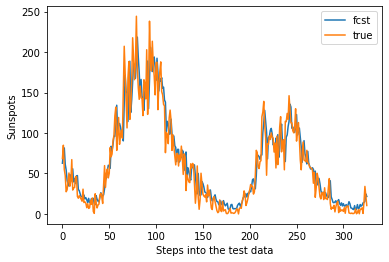

In [57]:
plt.plot(list(rf_regr.predict(X_test)))
plt.plot(list(y_test))
plt.legend(['fcst','true'])
plt.ylabel('Sunspots')
plt.xlabel('Steps into the test data')
plt.show()

In [58]:
#Feature Importance

fi = pd.DataFrame({'feature': X_train.columns, 'importance': rf_regr.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)

,feature,importance
2,sunspot_number_lag_1,0.63901
3,sunspot_number_lag_2,0.17440
4,sunspot_number_lag_3,0.06866
5,sunspot_number_lag_4,0.02156
6,sunspot_number_lag_5,0.01239
7,sunspot_number_lag_6,0.01141
10,sunspot_number_lag_9,0.01010
12,sunspot_number_lag_11,0.01004
9,sunspot_number_lag_8,0.00960
11,sunspot_number_lag_10,0.00951
